# Problem Statement

Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

# Task

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

# Data Description

* id: Unique ID for the customer
* Gender: Gender of the customer
* Age: Age of the customer
* Driving_License:
    * 0 : Customer does not have DL
    * 1 : Customer already has DL
* Region_Code: Unique code for the region of the customer
* Previously_Insured:
    * 1 : Customer already has Vehicle Insurance
    * 0 : Customer doesn't have Vehicle Insurance
* Vehicle_Age: Age of the Vehicle
* Vehicle_Damage:
    * 1 : Customer got his/her vehicle damaged in the past.
    * 0 : Customer didn't get his/her vehicle damaged in the past.
* Annual_Premium: The amount customer needs to pay as premium in the year
* PolicySalesChannel: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* Vintage: Number of Days, Customer has been associated with the company
* Response:
    * 1 : Customer is interested
    * 0 : Customer is not interested
    
# Leaderboard
* Public LB: 85.80% (rank=135)
* Private LB: 86.28% (rank=105)

[Link to the Leaderboard.](https://datahack.analyticsvidhya.com/contest/janatahack-cross-sell-prediction/#LeaderBoard)

# **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import ShuffleSplit, cross_val_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/health-insurance-cross-sell-prediction/train.csv
/kaggle/input/health-insurance-cross-sell-prediction/test.csv
/kaggle/input/health-insurance-cross-sell-prediction/sample_submission.csv


# Loading the data

In [2]:
train_orig= pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/train.csv')
test_orig= pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/test.csv')
subm= pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/sample_submission.csv')

In [3]:
train_orig.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
test_orig.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


# Exploratory Data Analysis

In [5]:
train_orig.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [6]:
test_orig.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

In [7]:
for col in test_orig.columns:
    print(f"{col}")
    print(f"Train:{train_orig[col].nunique()}\nTest:{test_orig[col].nunique()}")
    print("===============================")

id
Train:381109
Test:127037
Gender
Train:2
Test:2
Age
Train:66
Test:66
Driving_License
Train:2
Test:2
Region_Code
Train:53
Test:53
Previously_Insured
Train:2
Test:2
Vehicle_Age
Train:3
Test:3
Vehicle_Damage
Train:2
Test:2
Annual_Premium
Train:48838
Test:36327
Policy_Sales_Channel
Train:155
Test:145
Vintage
Train:290
Test:290


In [8]:
train_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


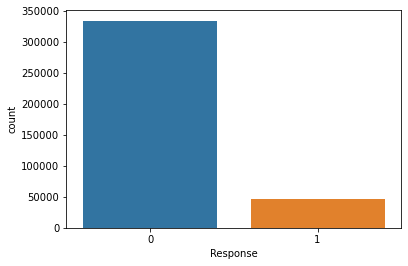

In [9]:
sns.countplot(x='Response',data=train_orig);

**Imbalanced Binary Classification Problem**

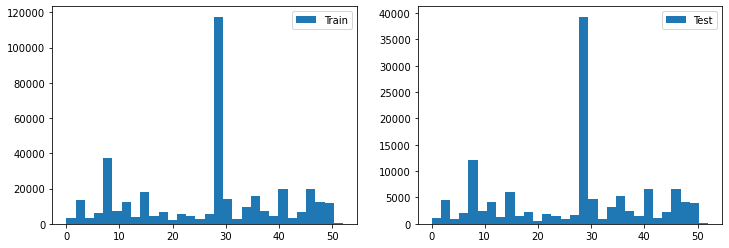

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(train_orig['Region_Code'],bins=30,label='Train');
plt.legend()
plt.subplot(1,2,2)
plt.hist(test_orig['Region_Code'],bins=30,label='Test');
plt.legend();

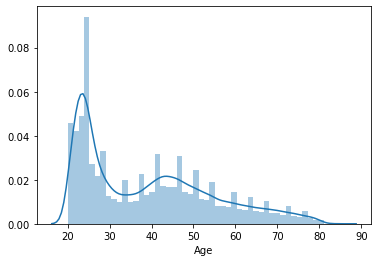

In [11]:
sns.distplot(train_orig['Age']);

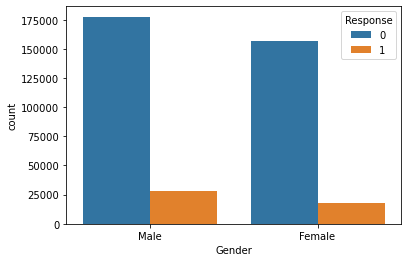

In [12]:
sns.countplot(x='Gender',data=train_orig,hue='Response');

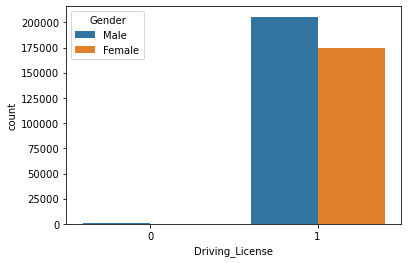

In [13]:
sns.countplot(x='Driving_License',data=train_orig,hue='Gender');

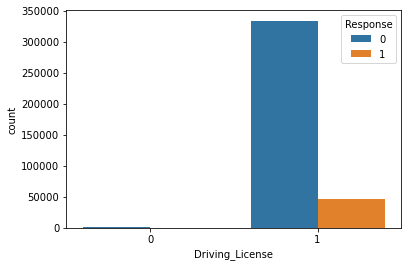

In [14]:
sns.countplot(x='Driving_License',data=train_orig,hue='Response');

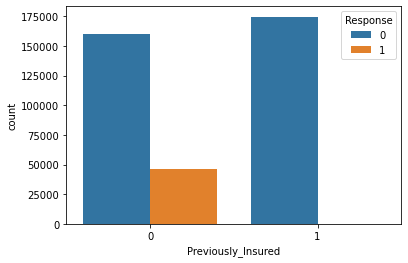

In [15]:
sns.countplot(x='Previously_Insured',data=train_orig,hue='Response');

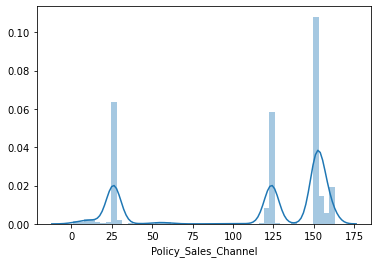

In [16]:
sns.distplot(train_orig['Policy_Sales_Channel']);

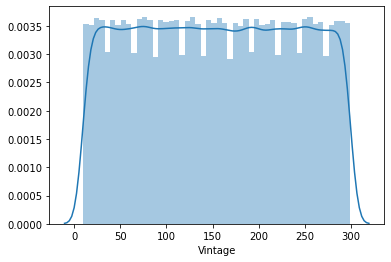

In [17]:
sns.distplot(train_orig['Vintage']);

## Concatenating train and test set for further inspection

In [18]:
data= pd.concat([train_orig,test_orig],axis=0,sort=False)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508146 entries, 0 to 127036
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    508146 non-null  int64  
 1   Gender                508146 non-null  object 
 2   Age                   508146 non-null  int64  
 3   Driving_License       508146 non-null  int64  
 4   Region_Code           508146 non-null  float64
 5   Previously_Insured    508146 non-null  int64  
 6   Vehicle_Age           508146 non-null  object 
 7   Vehicle_Damage        508146 non-null  object 
 8   Annual_Premium        508146 non-null  float64
 9   Policy_Sales_Channel  508146 non-null  float64
 10  Vintage               508146 non-null  int64  
 11  Response              381109 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 50.4+ MB


In [20]:
data.nunique()

id                      508146
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           52062
Policy_Sales_Channel       157
Vintage                    290
Response                     2
dtype: int64

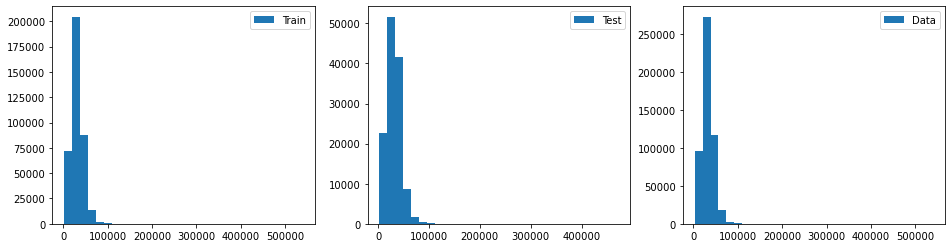

In [21]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.hist(train_orig['Annual_Premium'],bins=30,label='Train');
plt.legend()
plt.subplot(1,3,2)
plt.hist(test_orig['Annual_Premium'],bins=30,label='Test');
plt.legend();
plt.subplot(1,3,3)
plt.hist(data['Annual_Premium'],bins=30,label='Data');
plt.legend();

## Treating Outliers

In [22]:
def outliers(df, variable, distance):

    # Let's calculate the boundaries outside which the outliers are for skewed distributions

    # distance passed as an argument, gives us the option to estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

upper_limit, lower_limit = outliers(data, 'Annual_Premium', 1.5)
upper_limit, lower_limit

(61937.875, 1846.875)

In [23]:
data['Annual_Premium']= np.where(data['Annual_Premium'] > upper_limit, upper_limit,
                       np.where(data['Annual_Premium'] < lower_limit, lower_limit, data['Annual_Premium']))

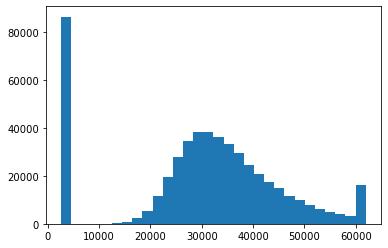

In [24]:
plt.hist(data['Annual_Premium'],bins=30);

## Feature Generation

In [25]:
data['Vehicle_Age'].value_counts()

1-2 Year     267015
< 1 Year     219805
> 2 Years     21326
Name: Vehicle_Age, dtype: int64

In [26]:
data.groupby(['Gender','Driving_License','Response']).size()

Gender  Driving_License  Response
Female  0                0.0            198
                         1.0             14
        1                0.0         156637
                         1.0          18171
Male    0                0.0            573
                         1.0             27
        1                0.0         176991
                         1.0          28498
dtype: int64

In [27]:
data['Driving_License']= data['Driving_License'].astype(str)
data['DL_Gender']= data['Driving_License']+'_'+ data['Gender']
data['Driving_License']= data['Driving_License'].astype(int)

In [28]:
data.groupby(['Vehicle_Age','Vehicle_Damage']).size()

Vehicle_Age  Vehicle_Damage
1-2 Year     No                 96136
             Yes               170879
< 1 Year     No                155738
             Yes                64067
> 2 Years    No                    24
             Yes                21302
dtype: int64

In [29]:
data['Vehicle_Age_and_Damage']= data['Vehicle_Age']+'_'+data['Vehicle_Damage']

In [30]:
data.groupby(['Vehicle_Age','Previously_Insured']).size()

Vehicle_Age  Previously_Insured
1-2 Year     0                     179945
             1                      87070
< 1 Year     0                      73861
             1                     145944
> 2 Years    0                      21270
             1                         56
dtype: int64

In [31]:
data['Previously_Insured']= data['Previously_Insured'].astype(str)
data['Previously_Insured_Vehicle_Age']= data['Vehicle_Age']+'_'+data['Previously_Insured']
data['Previously_Insured']= data['Previously_Insured'].astype(int)

In [32]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,DL_Gender,Vehicle_Age_and_Damage,Previously_Insured_Vehicle_Age
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1.0,1_Male,> 2 Years_Yes,> 2 Years_0
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0.0,1_Male,1-2 Year_No,1-2 Year_0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1.0,1_Male,> 2 Years_Yes,> 2 Years_0
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0.0,1_Male,< 1 Year_No,< 1 Year_1
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0.0,1_Female,< 1 Year_No,< 1 Year_1


In [33]:
data['Vintage']= data['Vintage'].apply(lambda x: x/365)

## Encoding the data

In [34]:
gender_map= {'Male':0,'Female':1}
vehicle_age_map= {'< 1 Year':0,'1-2 Year':1,'> 2 Years':2}
vehicle_damage_map= {'Yes':1,'No':0}

data['Gender']= data['Gender'].map(gender_map)
data['Vehicle_Age']= data['Vehicle_Age'].map(vehicle_age_map)
data['Vehicle_Damage']= data['Vehicle_Damage'].map(vehicle_damage_map)

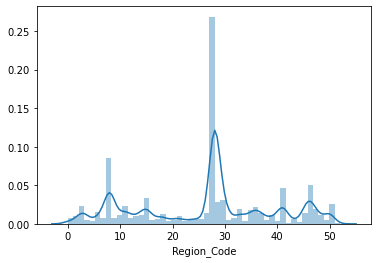

In [35]:
sns.distplot(data['Region_Code']);

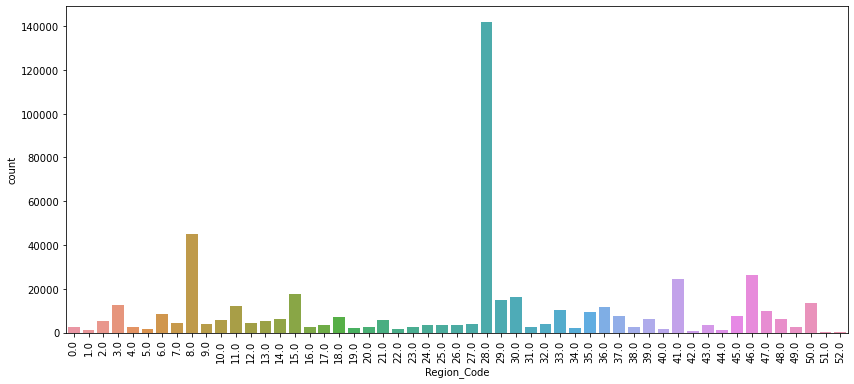

In [36]:
plt.figure(figsize=(14,6))
sns.countplot(x='Region_Code',data=data);
plt.xticks(rotation=90);

In [37]:
data.dtypes

id                                  int64
Gender                              int64
Age                                 int64
Driving_License                     int64
Region_Code                       float64
Previously_Insured                  int64
Vehicle_Age                         int64
Vehicle_Damage                      int64
Annual_Premium                    float64
Policy_Sales_Channel              float64
Vintage                           float64
Response                          float64
DL_Gender                          object
Vehicle_Age_and_Damage             object
Previously_Insured_Vehicle_Age     object
dtype: object

In [38]:
cat_col= [col for col in data.columns if data[col].dtypes=='object']
cat_col

['DL_Gender', 'Vehicle_Age_and_Damage', 'Previously_Insured_Vehicle_Age']

In [39]:
for col in cat_col:
    dummies= pd.get_dummies(data[col])
    data=pd.concat([data,dummies],axis=1)
    data.drop(columns=[col],inplace=True)

**Dropping unnecessary columns.**

In [40]:
data.drop(columns=['id','Response','Driving_License','0_Female'],inplace=True)

In [41]:
data.head().T

,0,1,2,3,4
Gender,0.000000,0.00000,0.000000,0.000000,1.000000
Age,44.000000,76.00000,47.000000,21.000000,29.000000
Region_Code,28.000000,3.00000,28.000000,11.000000,41.000000
Previously_Insured,0.000000,0.00000,0.000000,1.000000,1.000000
Vehicle_Age,2.000000,1.00000,2.000000,0.000000,0.000000
Vehicle_Damage,1.000000,0.00000,1.000000,0.000000,0.000000
Annual_Premium,40454.000000,33536.00000,38294.000000,28619.000000,27496.000000
Policy_Sales_Channel,26.000000,26.00000,26.000000,152.000000,152.000000
Vintage,0.594521,0.50137,0.073973,0.556164,0.106849
0_Male,0.000000,0.00000,0.000000,0.000000,0.000000


## Splitting back the data to train and test set.

In [42]:
train_new= data[:len(train_orig)]
test_new= data[len(train_orig):]

## Imbalanced binary classification- Using Oversampler

In [43]:
train_os=RandomOverSampler(random_state=101)
y=train_orig['Response']

X_os,y_os=train_os.fit_sample(train_new,y)

In [44]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_os))) 

Original dataset shape Counter({0: 334399, 1: 46710})
Resampled dataset shape Counter({1: 334399, 0: 334399})


In [45]:
#y= train_orig['Response']

X_train, X_val, y_train, y_val = train_test_split(X_os, y_os, test_size=0.3, random_state=101)

In [46]:
check= pd.concat([train_new,pd.DataFrame(data=train_orig['Response'],columns=['Response'])],axis=1,sort=False)

**checking the correlation of data**

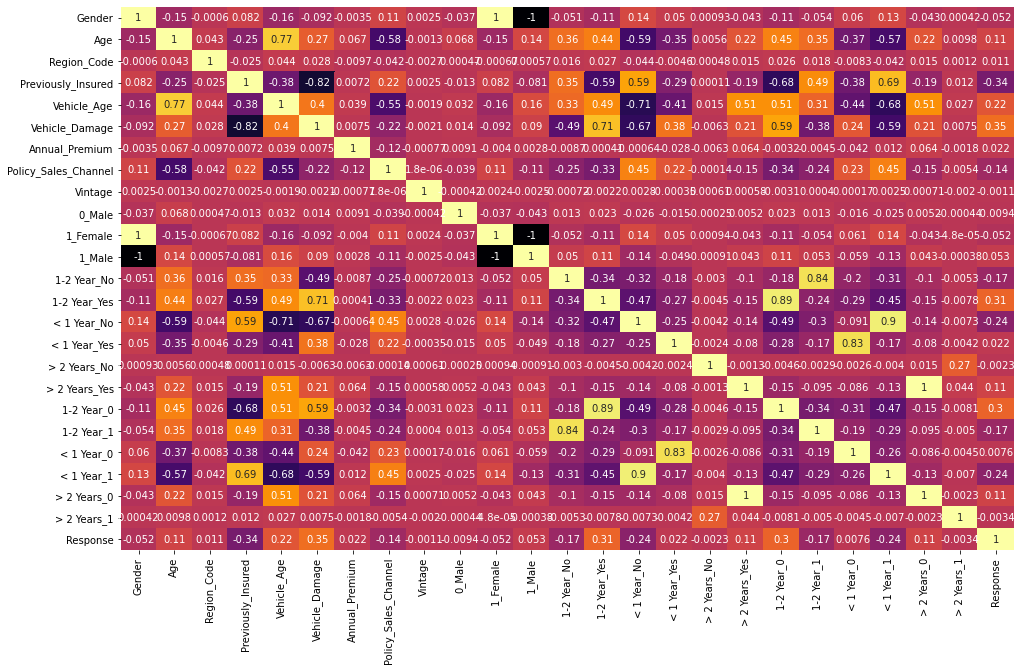

In [47]:
plt.figure(figsize=(16,10))
sns.heatmap(check.corr(),cbar=False,cmap='inferno',annot=True);

In [48]:
check.corr()["Response"].sort_values()

Previously_Insured     -0.341170
< 1 Year_No            -0.241425
< 1 Year_1             -0.235839
1-2 Year_No            -0.168342
1-2 Year_1             -0.167971
Policy_Sales_Channel   -0.139042
Gender                 -0.052440
1_Female               -0.052252
0_Male                 -0.009392
> 2 Years_1            -0.003378
> 2 Years_No           -0.002345
Vintage                -0.001050
< 1 Year_0              0.007579
Region_Code             0.010570
< 1 Year_Yes            0.021881
Annual_Premium          0.022057
1_Male                  0.053174
> 2 Years_Yes           0.109422
> 2 Years_0             0.109636
Age                     0.111147
Vehicle_Age             0.221874
1-2 Year_0              0.303912
1-2 Year_Yes            0.313186
Vehicle_Damage          0.354400
Response                1.000000
Name: Response, dtype: float64

# Model building- LGBMClassifier

In [49]:
model= LGBMClassifier(boosting_type='gbdt',objective='binary',random_state=101)

# Hyperparameter tuning

In [50]:
#model_tuning.best_estimator_

In [51]:
model=LGBMClassifier(colsample_bytree=0.5, learning_rate=0.03,
                     n_estimators=600, objective='binary', reg_alpha=0.1,
                     random_state=101,reg_lambda=0.8)

model.fit(X_train,y_train)

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.03, n_estimators=600,
               objective='binary', random_state=101, reg_alpha=0.1,
               reg_lambda=0.8)

In [52]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores=cross_val_score(model, X_val, y_val, cv=cv,scoring='roc_auc')
scores.mean()

0.8621796288560294

In [53]:
val_pred= model.predict_proba(X_val)[:,1]

In [54]:
val_pred

array([0.7255665 , 0.76566746, 0.00116814, ..., 0.00340806, 0.79594706,
       0.21848363])

In [55]:
print(roc_auc_score(y_val,val_pred))

0.8639176278141021


In [56]:
pred= model.predict_proba(test_new)[:,1]

# File submission

In [57]:
subm.head()

,id,Response
0,381110,0
1,381111,0
2,381112,0
3,381113,0
4,381114,0


In [58]:
subm['Response']= pred

In [59]:
subm.to_csv('submission.csv',index=False)

# Thank You
# Please upvote, if you find it insightful.